**Import dependencies and verify enviroment conforms to standards**

In [60]:
import gym
from gym.utils.env_checker import check_env
import numpy as np
import addiction_simulation
import sys, os, pickle
from rl_algorithms import EnhancedAwryQLearning, AwryQLearning, QLearning, RLBase

env = gym.make('AddictionEnv-v0')

assert env.spec.max_episode_steps is not None
# assert env.spec.autoreset is True
check_env(env.unwrapped)

In [61]:
def run_learning(env, agent: RLBase, render: bool=False, episodes: int=40, time_steps: int=200):
    """
    function to run independent q-learning algorithm on a gym env
    env is the gym env object
    n_agents is the number of agents
    render determines whether to render the env
    episodes is the number of episodes to simulate
    time steps is the maximum number of time steps per episode
    returns obvs, actions, rewards and losses of all agents
    """
    #init arrays to collect data
    all_obs = []
    all_actions = []
    all_rewards = []
    max_expected = []

    #render env if enabled
    if render:
        env.render()

    
    state, info = env.reset()
    for e in range(episodes): 
        state, info = env.reset()
        agent.reset(state)
        done = truncated = False

        for t in range(time_steps):
            if render:
                env.render()

            max_expected.append(np.max(agent.q_table[state]))
            action = agent.get_action(state)
            next_state, reward, done, truncated, info = env.step(action)               
            agent.train(state, action, reward, next_state)
            state = next_state
            
            if(done or truncated):
                break      

        all_obs.append(agent.ep_obs)
        all_actions.append(agent.ep_actions)
        all_rewards.append(agent.ep_rewards)
    
        agent.decay_epsilon(e)

    return all_obs, all_actions, all_rewards, max_expected

In [62]:
def override_params(params: dict, **kwargs):
    return dict(params, **kwargs)

params = {
    "n_states": env.observation_space.n,
    "n_actions": env.action_space.n,
    "gamma": 0.75,
    "epsilon_max": 0.25,
    "epsilon_min": 0.0001,
    "epsilon_decay": 0.99,
    "lr": 0.6,
    "saved_path": None,
    "debug": True
}

agents = [
    # QLearning(**params),
    # AwryQLearning(**params, dopamine_surge=0),
    # AwryQLearning(**params),
    # EnhancedAwryQLearning(**params, sigma=0.005, lambda_=0.0003, basal_lim=3),
    EnhancedAwryQLearning(**params, sigma=0.005, lambda_=0.0003, basal_lim=3),
    # EnhancedAwryQLearning(**params, sigma=0.005, lambda_=0.0003, basal_lim=7),
]
    

The policies given for the agents passed into the given environment is: Counter({1: 10})
The policies given for the agents passed into the given environment is: Counter({1: 10})
The policies given for the agents passed into the given environment is: Counter({1: 9, 0: 1})
The policies given for the agents passed into the given environment is: Counter({1: 6, 0: 4})
The policies given for the agents passed into the given environment is: Counter({0: 8, 1: 2})
The policies given for the agents passed into the given environment is: Counter({0: 10})
The policies given for the agents passed into the given environment is: Counter({0: 10})
The policies given for the agents passed into the given environment is: Counter({0: 10})


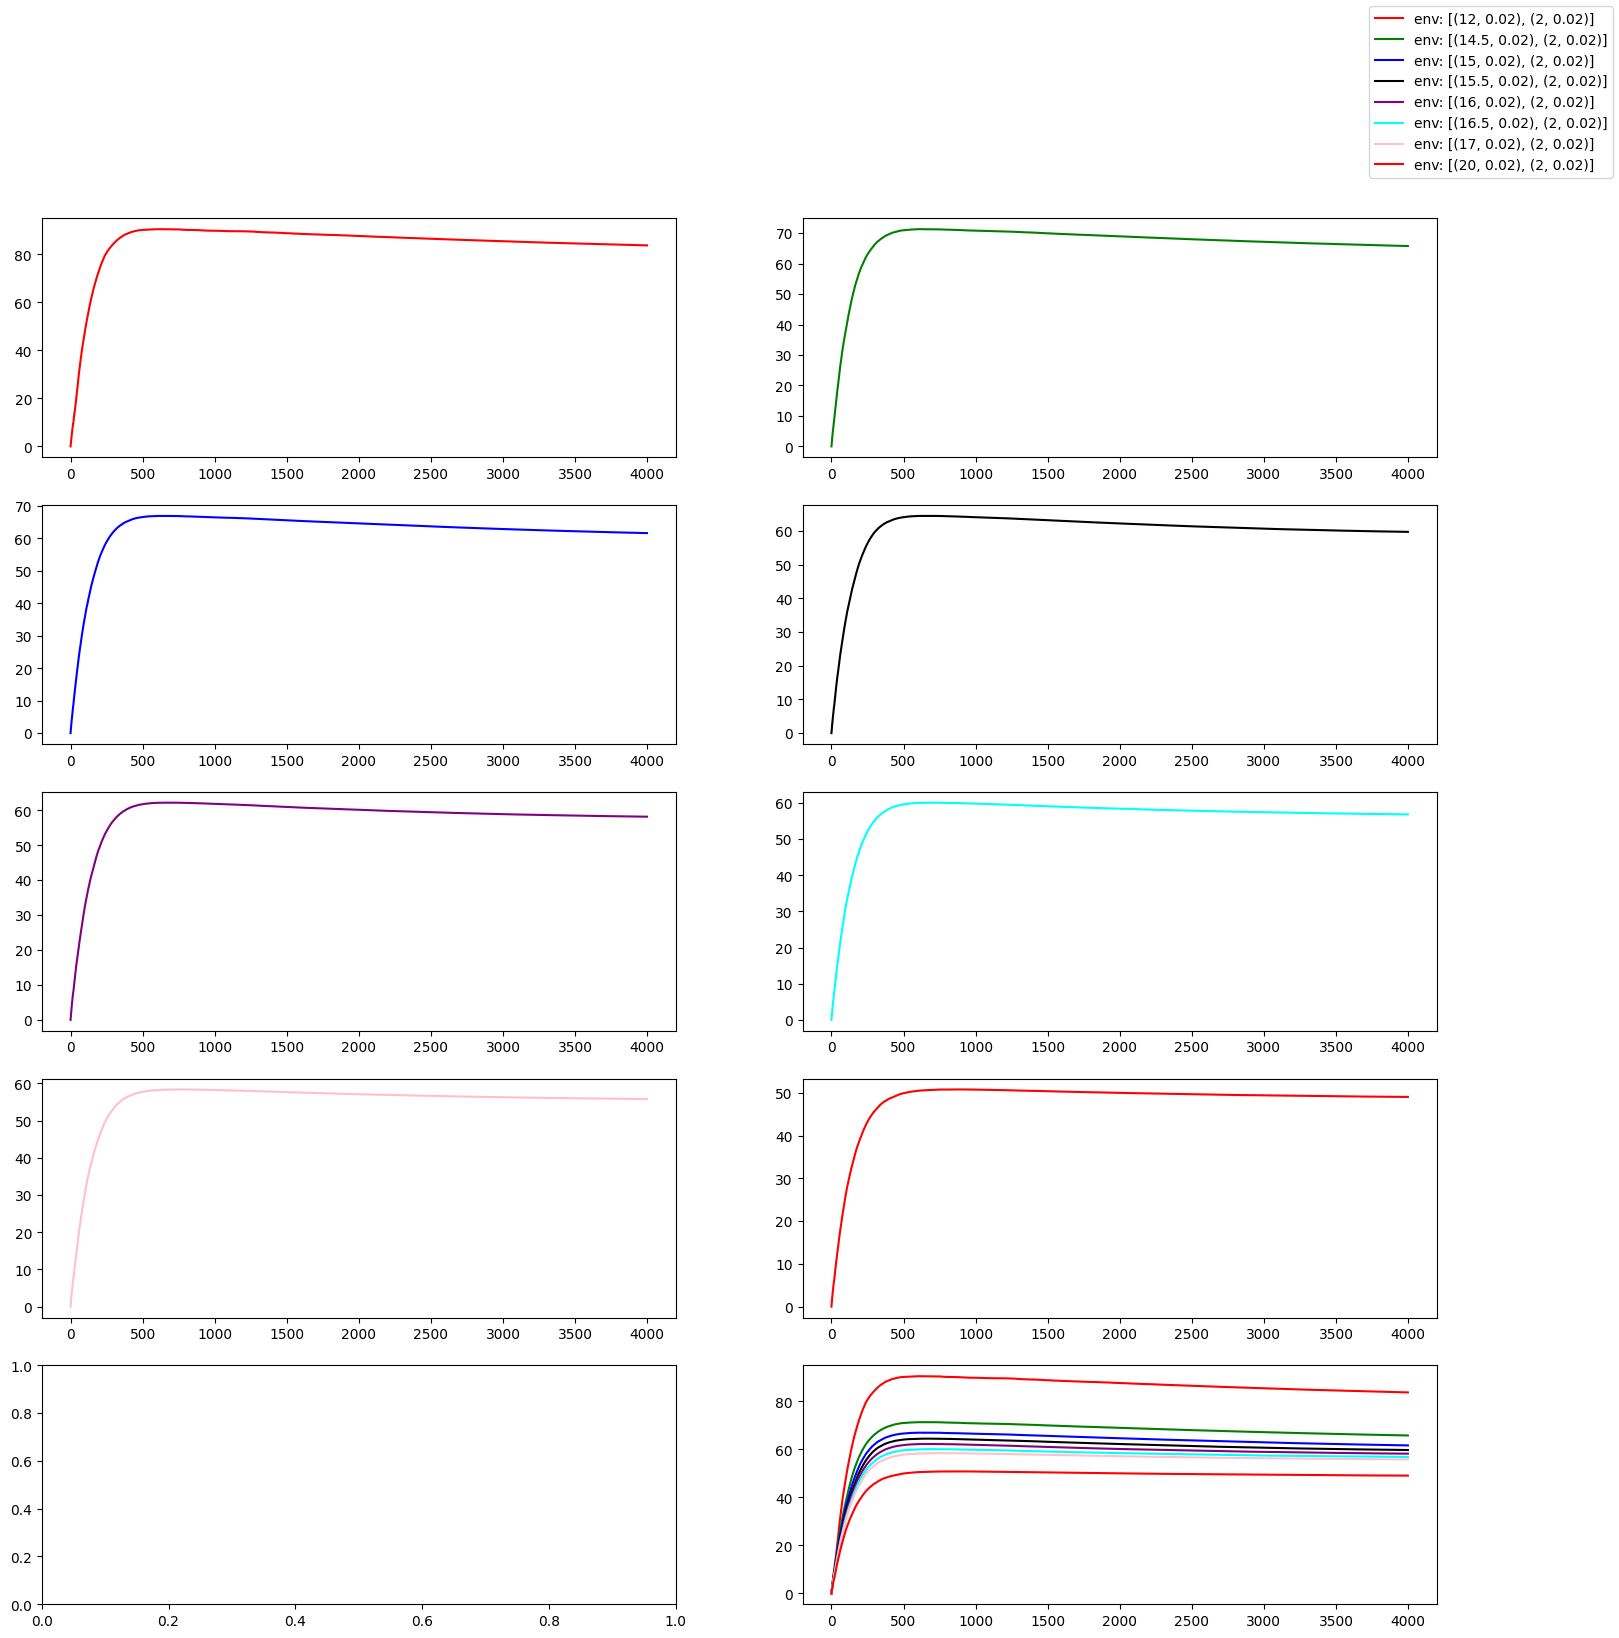

In [63]:
from collections import Counter
import matplotlib.pyplot as plt

mxp = []

envs = [
    gym.make('AddictionEnv-v0', rewards=[(12, 0.02), (2, 0.02)]),
    gym.make('AddictionEnv-v0', rewards=[(14.5, 0.02), (2, 0.02)]),
    gym.make('AddictionEnv-v0', rewards=[(15, 0.02), (2, 0.02)]),
    gym.make('AddictionEnv-v0', rewards=[(15.5, 0.02), (2, 0.02)]),
    gym.make('AddictionEnv-v0', rewards=[(16, 0.02), (2, 0.02)]),
    gym.make('AddictionEnv-v0', rewards=[(16.5, 0.02), (2, 0.02)]),
    gym.make('AddictionEnv-v0', rewards=[(17, 0.02), (2, 0.02)]),
    gym.make('AddictionEnv-v0', rewards=[(20, 0.02), (2, 0.02)]),
]

colours = ["red", "green", "blue", "black", "purple", "cyan", "pink"]
fig, ax = plt.subplots(nrows=(len(envs) + 2) // 2, ncols=2, figsize=(18, 18))
for j, env in enumerate(envs):
    policies = []
    for k in range(10):
        env.reset()
        for i, agent in enumerate(agents):
            agent.wipe()

            print(f"Running trial {k} for {type(agent).__name__} agent...", end="\r", flush=True)

            obs, actions, rewards, max_expected = run_learning(env, agent)
            mxp.append(max_expected)
            # print(f"Policy: {agent.get_policy()}" ,end=(" "*40 + "\n"))
            # print(f"Mean reward in training: {np.mean(rewards):.3f}")
            # print(f"Action counts: {Counter(np.array(actions).flatten()).most_common()}")
            
            # timesteps = 1000
            # total_reward = 0
            # state, info = env.reset()
            # for _ in range(timesteps):
            #     action = agent.get_action(state)
            #     state, reward, done, _, _ = env.step(action)
            #     total_reward += reward
            # print(f"Mean reward in testing: {total_reward / timesteps:.3f}", end="\n\n")
            policies.append(agent.get_policy()[0])

    normalise_rewards = np.mean(mxp, axis=0) / (max(env.rewards[0][0], env.rewards[0][1]))
    ax[j // 2, j % 2].plot(normalise_rewards, label=f"env: {env.rewards}", color=colours[j % len(colours)])
    ax[-1, -1].plot(normalise_rewards, color=colours[j % len(colours)])
    print(f"The policies given for the agents passed into the given environment is: {Counter(policies)}")

fig.legend()